In [1]:
import ROOT
ROOT.PyConfig.IgnoreCommandLineOptions = True
ROOT.gROOT.ProcessLine(".L RooTwoSidedCBShape.cxx")

#Silence RooFit
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.NumIntegration)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Fitting)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Minimization)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.InputArguments)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Eval)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.DataHandling)
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.ERROR)
ROOT.RooMsgService.instance().setSilentMode(True)
ROOT.PyConfig.IgnoreCommandLineOptions = True
ROOT.gROOT.SetBatch(True) 

Welcome to JupyROOT 6.16/00


In [2]:
import numpy as np
import sys
sys.path.append('..')
from common import common

import logging
logging.basicConfig(level=logging.DEBUG)

In [3]:
def create_workspace():                                                                                                                               
    ws = ROOT.RooWorkspace('signalWS')                                                                                                                
    ws.factory('mass[105E3, 160E3]')
    ws.factory('m0[125E3, 123E3, 127E3]')                                                                                                             
    ws.factory('sigma[2E3, 0.5E3, 4E3]')                                                                                                              
    ws.factory('alphaLo[2, 0.5, 4]')                                                                                                                  
    ws.factory('nLo[10, 0.1, 100]')                                                                                                                   
    ws.factory('alphaHi[2, 0.5, 4]')                                                                                                                  
    ws.factory('nHi[5, 0.1, 10]')                                                                                                                     
    ws.factory('RooTwoSidedCBShape::signal(mass, m0, sigma, alphaLo, nLo, alphaHi, nHi)')                                                                                                                                         
    return ws

def get_histogram(f, quantity, ibin):                                                                                                                 
    hist_name = 'histo2d_m_yy_%s__All_isPassed' % quantity                                                                                            
    logging.info('Getting histogram 2d %s' % hist_name)                                                                                               
    hist2d = f.Get(hist_name).Clone()                                                                                                                 
    w_initial_plusDalitz = f.Get('w_initial_plusDalitz').GetBinContent(1)                                                                             
    hist2d.Scale(1. / w_initial_plusDalitz)                                                                                                           
    hist1d = hist2d.ProjectionY('_py', ibin, ibin)                                                                                                    
    return hist1d                                                                                                                                     
                                                                                                                                                      
def fit_histo(histo, pdf, obs):                                                                                                                       
    rdh = ROOT.RooDataHist('root_data_hist', 'root_data_hist', ROOT.RooArgList(obs), histo)                                                           
    fr = pdf.fitTo(rdh,                                                                                                                               
                   ROOT.RooFit.PrintLevel(-1),                                                                                                        
                   ROOT.RooFit.SumW2Error(True),                                                                                                      
                   ROOT.RooFit.Save())                                                                                                                
    return fr

In [4]:
fname = '../merged_normalized_final/mcAll_prodAll_MxAODJetSys._sysNominal.merged.norm.root'
quantity = 'pT_yy'
binning = common.binnings[quantity]
ibin = 4
min_range = 110000
max_range = 140000

In [5]:
f = ROOT.TFile.Open(fname)

In [6]:
ws = create_workspace()
ws.saveSnapshot('initial', ws.allVars())

pdf = ws.pdf('signal')
obs = ws.var('mass')
histo = get_histogram(f, quantity, ibin)
fr = fit_histo(histo, pdf, obs)

INFO:root:Getting histogram 2d histo2d_m_yy_pT_yy__All_isPassed


In [7]:
plot_info = [
    ('#it{ATLAS #it{#bf{Preliminary}}}', 0.14, 0.8),
    (r'$\sqrt{s} = 13 \text{ TeV; L} = 140 \text{ fb}^{-1}$', 0.123, 0.73),
    (r'%d \text{ [GeV]}< %s < %d \text{ [GeV]}' % (binning[ibin-1] / 1000, 
                                                   'p_T^{\gamma\gamma}', 
                                                   binning[ibin] / 1000), 0.14, 0.66)
]

parameters_info = [
    (r'\mu_{CB} = %.3f' % (ws.var('m0').getVal()/1000), 0.7, 0.8),
    (r'\sigma_{CB} = %.3f' % (ws.var('sigma').getVal()/1000), 0.7, 0.73),
    (r'\alpha_{Hi} = %.3f' % (ws.var('alphaHi').getVal()), 0.7, 0.66),
    (r'\alpha_{Lo} = %.3f' % (ws.var('alphaLo').getVal()), 0.7, 0.59),
    (r'#bf{n_{Hi} = %.3f}' % (ws.var('nHi').getVal()), 0.7, 0.51),
    (r'#bf{n_{Lo} = %.3f}' % (ws.var('nLo').getVal()), 0.7, 0.45)
    ]

In [8]:
from ROOT import TCanvas, TColor, TGaxis, TH1F, TPad, TLine

def create_canvas_pads():
    c = TCanvas("c", "canvas", 800, 600)
    pad1 = TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0)
    pad1.Draw()
    
    c.cd()
    pad2 = TPad("pad2", "pad2", 0, 0, 1, 0.3)
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.2)
    pad2.Draw()
    return c, pad1, pad2

def create_histo_plot(observable, histo, plot_info, parameters_info):
    frame = observable.frame(ROOT.RooFit.Range(int(min_range), int(max_range)))
    rdh = ROOT.RooDataHist('root_data_hist', 'root_data_hist', ROOT.RooArgList(obs), histo)
    for name, x_val, y_val in plot_info:
        txt = ROOT.TLatex(x_val, y_val, name)
        txt.SetNDC()
        txt.SetTextSize(0.045)
        frame.addObject(txt)

    for name, x_val, y_val in parameters_info:
        txt = ROOT.TLatex(x_val, y_val, name)
        txt.SetNDC()
        txt.SetTextSize(0.045)
        frame.addObject(txt)
    
    rdh.plotOn(frame, ROOT.RooFit.Binning(55))
    pdf.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kRed -4))
    frame.GetXaxis().SetLabelSize(0.)
    return frame

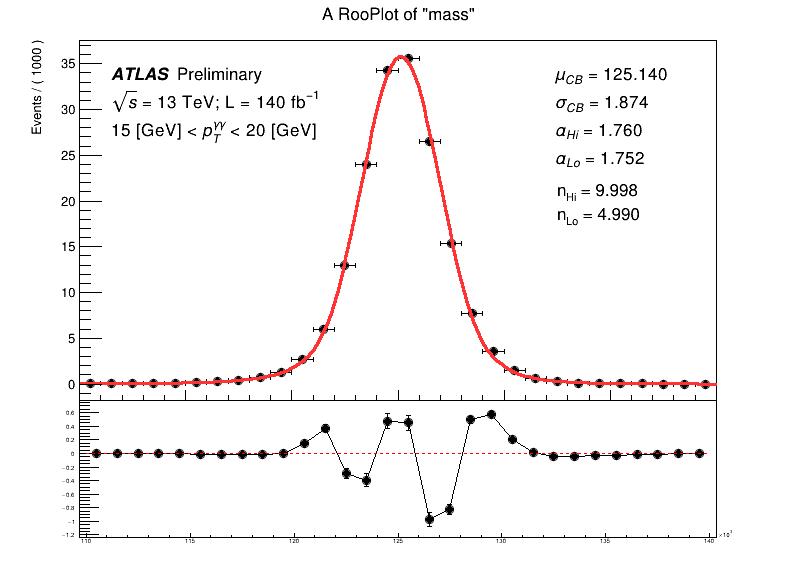

In [9]:
frame = create_histo_plot(obs, histo, plot_info, parameters_info)
canvas, pad1, pad2 = create_canvas_pads()

resid = frame.residHist()

pad1.cd()
ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)
frame.Draw()

pad2.cd()

resid.GetXaxis().SetRangeUser(110000, 140000)
resid.SetTitle('')
resid.Draw()

line = TLine(110000, 0, 140000, 0)
line.SetLineColor(ROOT.kRed)
line.SetLineStyle(2)
line.Draw()

canvas.Draw()

In [10]:
from matplotlib import pyplot as plt
import matplotlib as mpl

DEBUG:matplotlib:$HOME=/home/mario
DEBUG:matplotlib:matplotlib data path /home/mario/venv_py/local/lib/python2.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/mario/venv_py/local/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 2.2.4
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux2
DEBUG:matplotlib:loaded modules: ['numpy.core.info', 'traitlets.config.decorator', 'ROOT.TAttFill', 'distutils.sysconfig', 'pygments.filters', 'IPython.utils.pprint', 'logging.weakref', 'dateutil.tz.os', 'pprint', 'prompt_toolkit.key_binding.bindings.vi', 'ipykernel.traitlets', 'ROOT.TArray', 'JupyROOT.magics.jsrootmagic', 'IPython.terminal.sys', 'ROOT.PyROOT', 'ROOT.TStyle', 'numpy.core._multiarray_tests', 'ROOT.ROOT.VecOps.RVec<long>', 'IPython.terminal.embed', 'jupyter_core.sys', 'cmd', 'IPython.core.magics.auto', 'shlex', 'IPython.core.completerlib', 'zlib', 'ipywidgets.IPython', 'ipywidgets.widgets.domwidg

DEBUG:matplotlib:CACHEDIR=/home/mario/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/mario/.cache/matplotlib/fontList.json
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [73]:
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['figure.figsize'] = 8.75, 7.92

# font
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.fontset'] = 'stixsans'
mpl.rcParams['mathtext.default'] = 'rm'

mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

mpl.rcParams['legend.frameon'] = False

In [74]:
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

def ROOT_to_np_pfd(xaxis, pdf):
    pdf_array = []
    for x in xaxis:
        pdf_array.append(pdf.Eval(x))
    # Smoothing with BSpline
    xnew = np.linspace(np.min(xaxis), np.max(xaxis), len(xaxis)*10)
    spl = make_interp_spline(xaxis, pdf_array, k=3)
    np_pdf = spl(xnew)
    return pdf_array, np_pdf, xnew

def ROOT_to_np_histo(xaxis, histo):
    np_histo = []
    for x in xaxis:    
        np_histo.append(histo.Eval(x))
    return np_histo, xaxis

In [75]:
def get_parameters(ws):
    parameters_info = [
        (r'$\mu_{CB} = %.3f$' % (ws.var('m0').getVal()/1000), 0.7, 0.87),
        (r'$\sigma_{CB} = %.3f$' % (ws.var('sigma').getVal()/1000), 0.7, 0.78),
        (r'$\alpha_{Hi} = %.3f$' % (ws.var('alphaHi').getVal()), 0.7, 0.69),
        (r'$\alpha_{Lo} = %.3f$' % (ws.var('alphaLo').getVal()), 0.7, 0.60),
        (r'$n_{Hi} = %.3f$' % (ws.var('nHi').getVal()), 0.7, 0.51),
        (r'$n_{Lo} = %.3f$' % (ws.var('nLo').getVal()), 0.7, 0.42)
        ]
    return parameters_info

In [76]:
ratio = np.array(pdf_array) - np.array(np_histo)
len(ratio)

55

[105500. 106500. 107500. 108500. 109500. 110500. 111500. 112500. 113500.
 114500. 115500. 116500. 117500. 118500. 119500. 120500. 121500. 122500.
 123500. 124500. 125500. 126500. 127500. 128500. 129500. 130500. 131500.
 132500. 133500. 134500. 135500. 136500. 137500. 138500. 139500. 140500.
 141500. 142500. 143500. 144500. 145500. 146500. 147500. 148500. 149500.
 150500. 151500. 152500. 153500. 154500. 155500. 156500. 157500. 158500.
 159500.]


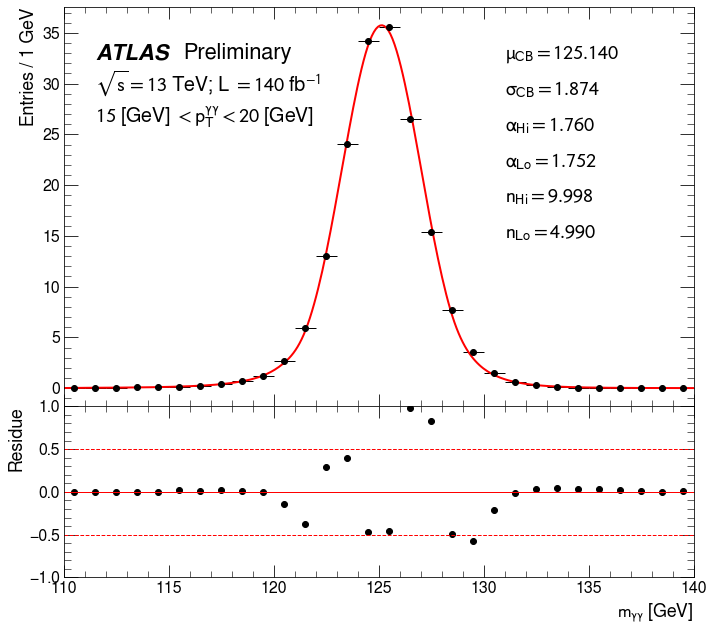

In [93]:
parameters_info = get_parameters(ws)
curve_pdf = frame.findObject('signal_Norm[mass]')
histo_data = frame.findObject('h_root_data_hist')
xs = histo_data.GetX()
xs.SetSize(histo_data.GetN())
xs = list(xs)

print(np.array(xs))
pdf_array, np_pdf, pdf_xaxis = ROOT_to_np_pfd(xs, curve_pdf)
np_histo, histo_xaxis = ROOT_to_np_histo(xs, histo_data)

fig, ax = plt.subplots(sharex=True)
ax = fig.add_axes((0.,0.3, 1., 0.7))
ax.errorbar(np.array(xs) / 1000, np_histo, xerr=0.5, fmt='o', color='k')
ax.plot(pdf_xaxis / 1000, np_pdf, color='red', lw=2)
ax.set_xlim(110, 140)
ax.set_ylabel('Entries / 1 GeV', horizontalalignment='right', y=1.0)
ax.get_xaxis().set_ticklabels([])

ax.text(0.05, 0.87, 'ATLAS', style='italic', fontweight='bold', transform=ax.transAxes, fontsize=22)
ax.text(0.19, 0.87, 'Preliminary', transform=ax.transAxes, fontsize=22)
ax.text(0.05, 0.79, r'$\sqrt{s} = 13$ TeV; L $= 140$ fb$^{-1}$', transform=ax.transAxes, fontsize=20)
ax.text(0.05, 0.71, r'$%d$ [GeV] $< %s < %d$ [GeV]' % (binning[ibin-1] / 1000,
                                                                  'p_T^{\gamma\gamma}',
                                                                  binning[ibin] / 1000),
                                                                transform=ax.transAxes, fontsize=20)

for name, x_val, y_val in parameters_info:
    ax.text(x_val, y_val, name, transform=ax.transAxes, fontsize=20)


ax = fig.add_axes((0.,0., 1., 0.3))
ax.plot(np.array(xs) / 1000, ratio, 'o', color='k')
ax.axhline(-0.5, ls='--', color='red')
ax.axhline(0, color='red')
ax.axhline(0.5, ls='--', color='red')
ax.set_xlim(110, 140)
ax.set_ylim(-1, 1)
ax.set_xlabel(r'$m_{\gamma\gamma}$ [GeV]', horizontalalignment='right', x=1.0)
ax.set_ylabel('Residue', horizontalalignment='right', y=1.0)

fig.savefig('plot_layout', bbox_inches='tight')